# Example notebook for usage with single-level data on the triangular grid

The grid and model data used here is located in the data subdirectory.

We use a 80km horizontal grid from the ICON atmosphere model with the physics package for numerical weather prediction ("ICON-NWP"). The model uses an unstructured triangular grid. The data is from a simulation over a limited-area domain over the North Atlantic in September 2016. We specifically use total cloud cover, which in ICON-NWP has values between 0 and 1.

Some more background on ICON is given, e.g., here:

*  Zaengl, G. et al, 2015: The ICON (ICOsahedral Non‐hydrostatic) modelling framework of DWD and MPI‐M: Description of the non‐hydrostatic dynamical core, QJRMS. https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.2378
*  https://www.dwd.de/EN/research/weatherforecasting/num_modelling/01_num_weather_prediction_modells/icon_description.html

The model simulation from which the data is taken is described in Senf, F., A. Voigt et al, 2020: Increasing Resolution and Resolving Convection Improve the Simulation of Cloud‐Radiative Effects Over the North Atlantic, JGR Atmospheres. https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JD032667. Specifically, the simulation belongs to Set 1 (see Table 2 of Senf, Voigt et al., 2020), and used the 1-moment cloud microphysical scheme, parametrized convection, and a horizontal grid with 80 km resolution. The latter leads to 7920 triangles per level.

## Load tricco package, and make external cc3d package available

This is system specific and will require some adaptation on a different machine.

In [1]:
import cc3d
import tricco

## Prepare grid

First, we need to read in the triangular grid and make it available to tricco. Here, this is done for the triangular grid of the ICON model.

In [2]:
tricco.grid_functions.grid = tricco.prepare_grid(model='ICON', path='./data/', 
                                                 file='icon-grid_nawdex_78w40e23n80n_R80000m.nc')

## Perform cubulation

We now perform the cubulation. That is, we map the indices of the triangular grid to the indices of the cubical grid. The former are a 1d array, the latter is a list, with each list entry mapping the triangular cell index to the 3d index on the cubical grid.

Note that we also need to specify the starting triangle and the search radius. For limited-area grids, the starting triangle should usually be in the middle of the grid. The radius defines the number of steps taken to enlarge the cubulated triangles "outward".

For the grid used here, start_triangle = 5570 is a good choice. As for the radius, use radius = 104 to cover the whole grid.

In [3]:
cubulation = tricco.compute_cubulation(start_triangle=5570, radius=104, print_progress=False)

For illustration, this is what cubulation looks like. The first ten entries are as follows:

In [4]:
cubulation[0:10]

[array([5570, array([52, 52, 52])], dtype=object),
 array([5566, array([53, 52, 52])], dtype=object),
 array([5573, array([52, 53, 52])], dtype=object),
 array([5567, array([52, 52, 53])], dtype=object),
 array([5736, array([53, 52, 51])], dtype=object),
 array([5563, array([53, 51, 52])], dtype=object),
 array([5577, array([52, 53, 51])], dtype=object),
 array([5571, array([51, 53, 52])], dtype=object),
 array([5568, array([51, 52, 53])], dtype=object),
 array([5569, array([52, 51, 53])], dtype=object)]

Because for a given grid the cubulation only needs to be done once, it might be helpful to save it for later use. We here simply use the native numpy array format.

In [5]:
import numpy as np
np.save('icon-grid_nawdex_78w40e23n80n_R80000m_cubulation_radius104_start5570', cubulation)

We now read in ICON data for total cloud cover. Field is the data on the ICON triangular grid, field_cube on the cube grid. Also, a threhold is applied to set all values of field to zero below the threshold, and to 1 above.

In [6]:
field, field_cube = tricco.prepare_field(model='ICON', path='./data/', 
                                         file='nawdexnwp-80km-mis-0001_2016092200_2d_30min_DOM01_ML_0060.nc',
                                         var='clct', threshold=85.0, cubulation=cubulation)

## Find connected components

Now we find the connected components and write them into a list of lists. The "sublists" contain the triangle indices that belong to the same
connected component.

### We first do this for vertex connectivity

In [7]:
components_vertex = tricco.compute_connected_components_2d(cubulation, field_cube, connectivity = 'vertex')

We sort the components by their size. This is not needed for the analysis but convenient for the plotting later.

In [8]:
components_vertex = sorted(components_vertex, key=len, reverse=True)

`components_vertex` is a list of components. It is straightforward to map it on the structure of the field input data, with the value indicating the connected component. Doing so can be handy for plotting for example. 0 means that the triangle does not belong to any connected component.

In [9]:
field_cc_vertex = np.zeros(field.size)
for icomp in range(len(components_vertex)):
    field_cc_vertex[components_vertex[icomp]]=icomp+1

#### And now for edge connectivity

In [10]:
components_edge = tricco.compute_connected_components_2d(cubulation, field_cube, connectivity = 'edge')

components_edge = sorted(components_edge, key=len, reverse=True)

field_cc_edge = np.zeros(field.size)
for icomp in range(len(components_edge)):
    field_cc_edge[components_edge[icomp]]=icomp+1

## Some sanity checks (purely optional)

We can do a few sanity checks.

1. The total number of triangles that belong to a connected component needs to be the same for vertex and edge connectivity, and needs to equal the sum of triangles for which field=1.

In [11]:
print('Total number of triangles that belong to some connected component for vertex connectivity:', np.sum([len(icomp) for icomp in components_vertex]))
print('Total number of triangles that belong to some connected component for edge   connectivity:', np.sum([len(icomp) for icomp in components_edge  ]))
print('Total number of triangles for which field has value 1:', np.sum(field==1))

Total number of triangles that belong to some connected component for vertex connectivity: 1932
Total number of triangles that belong to some connected component for edge   connectivity: 1932
Total number of triangles for which field has value 1: 1932


2. Vertex connectivity should have less connected components than edge connectivity.

In [12]:
print('Number of connected components for vertex connectivity:', len(components_vertex))
print('Number of connected components for edge   connectivity:', len(components_edge  ))

Number of connected components for vertex connectivity: 30
Number of connected components for edge   connectivity: 74


3. Let us plot the connected components for a visual inspection.

First we define a qualitative colormap that cycles through the colors of the matplotlib Set1 colormap, and that always plots 0 as white.

In [13]:
def make_colormap(ncolors):
    import matplotlib as mpl    
    cmap_base = plt.cm.Set1 # note: number of colors of base color map is given by cmap_base.N
    cmaplist_base = [cmap_base(i) for i in range(cmap_base.N)]
    cmaplist = [(1, 1, 1, 1.0)] # need to have white as first color for the triangles with no connected component
    for i in range(ncolors-1):
        icolor = np.mod(i,cmap_base.N)
        cmaplist.append(cmaplist_base[icolor])
    return mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, ncolors)

Now we plot the thresholded total cloud cover field, as well as the connected components for vertex and edge connectivity. For vertex connectivity, triangles touching at a shared vertex belong to the same component. For edge connectivity, only triangles that touch via a shared edge belong to the same connected component. Thus, edge connectivity is stricter and leads to more connected components. This plots below confirm this expectation.

For reference, the plot also contains non-thresholded total cloud cover, which we load below.

In [14]:
import xarray as xr
field_orig = xr.open_dataset('./data/nawdexnwp-80km-mis-0001_2016092200_2d_30min_DOM01_ML_0060.nc')['clct'].squeeze()

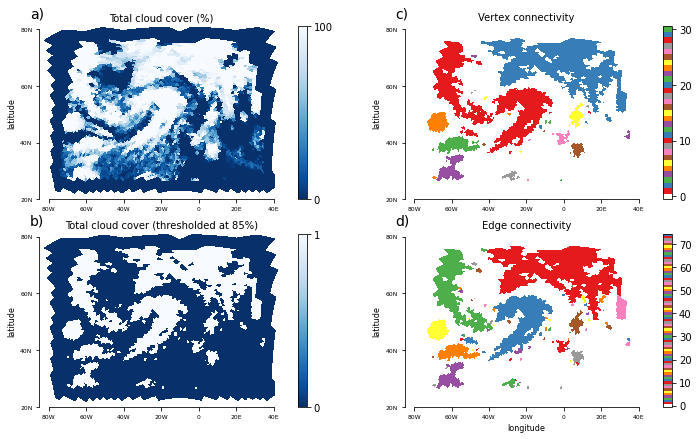

In [15]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

rad2deg=180.0/np.pi

import xarray as xr
ds_grid_plot  = xr.load_dataset('./data/icon-grid_nawdex_78w40e23n80n_R80000m.nc')
vlat = rad2deg*ds_grid_plot['vlat'].values
vlon = rad2deg*ds_grid_plot['vlon'].values
# we need to subtract -1 from vertex_of_cell as python starts counting at 0, but fortran starts at 1
vertex_of_cell= ds_grid_plot['vertex_of_cell'].values-1
del ds_grid_plot

def make_niceplot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(20,80)
    ax.spines['bottom'].set_bounds(-80,40)
    ax.yaxis.set_ticks([20,40,60,80])
    ax.yaxis.set_ticklabels(['20N','40N','60N','80N'], fontsize=6)
    ax.xaxis.set_ticks([-80,-60,-40,-20,0,20,40])
    ax.xaxis.set_ticklabels(['80W','60W','40W','20W','0','20E','40E'], fontsize=6)
    plt.xlim(-85,45); plt.ylim(20,81);
    plt.ylabel('latitude', fontsize=8)
    
# plotting
plt.figure(figsize=(12,7))

ax=plt.subplot(2,2,1); make_niceplot(ax)
plt.title('Total cloud cover (%)', fontsize=10)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field_orig,
                vmin=0, vmax=100, edgecolors='none', cmap=plt.get_cmap('Blues_r'))
plt.colorbar(c, ticks=[0,100]);
plt.text(-90,88, 'a)', color='k', size=14, ha='left', va='top')

ax=plt.subplot(2,2,3); make_niceplot(ax)
plt.title('Total cloud cover (thresholded at 85%)', fontsize=10)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field, 
                vmin=0, vmax=1, edgecolors='none', cmap=plt.get_cmap('Blues_r'))
plt.colorbar(c, ticks=[0,1]);
plt.text(-90,88, 'b)', color='k', size=14, ha='left', va='top')

ax=plt.subplot(2,2,2); make_niceplot(ax)
plt.title('Vertex connectivity', fontsize=10); make_niceplot(ax)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field_cc_vertex, 
                vmin=-0.5, vmax=len(components_vertex)+0.5, edgecolors='none', cmap=make_colormap(ncolors=len(components_vertex)+1))
plt.colorbar(c, ticks=[i for i in range(0,len(components_vertex)+1,10)]);
plt.text(-90,88, 'c)', color='k', size=14, ha='left', va='top')

ax=plt.subplot(2,2,4); make_niceplot(ax)
plt.title('Edge connectivity', fontsize=10); make_niceplot(ax)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field_cc_edge, 
                vmin=-0.5, vmax=len(components_edge)+0.5, edgecolors='none', cmap=make_colormap(ncolors=len(components_edge)+1))
plt.colorbar(c, ticks=[i for i in range(0,len(components_edge)+1,10)]);
plt.xlabel('longitude', fontsize=8);
plt.text(-90,88, 'd)', color='k', size=14, ha='left', va='top')

plt.savefig('example-2d_plot.pdf')